In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime
import numpy as np
from math import sin, pi

seq_len = 300
return_len = 20

<ipython-input-1-689fc5c876b0>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
df = pd.read_csv('./good_sber_1min_2023.csv', delimiter=',')
# Convert str to datetime in column "date"
"%Y-%m-%dT%H:%M:%SZ"
#df["date"] = pd.Series([datetime.strptime(x[:-6], "%Y-%m-%dT%H:%M:%S%Z" ) for x in df["date"]])
df['date'] = df["time"].apply(lambda x: datetime.fromisoformat(x[:-1]))
df.drop(columns=['name', 'Unnamed: 0', "time"], inplace=True)
#df.(df["date"], inplace=True)
df.head()

,open,close,high,low,volume,date
0,141.06,141.06,141.06,141.06,415,2023-01-01 09:00:00
1,140.62,140.84,141.26,139.98,864,2023-01-01 09:01:00
2,140.85,139.88,140.85,139.88,256,2023-01-01 09:02:00
3,140.60,139.63,140.86,139.63,518,2023-01-01 09:03:00
4,140.38,140.50,140.50,139.60,146,2023-01-01 09:04:00


In [ ]:
df["day_of_week"] = df["date"].apply(lambda x: sin(2*pi * x.weekday() / 7))
# df['day_of_year'] = df['date'].apply(lambda x: sin(2*pi * x.timetuple().tm_yday / 365))
df['time_of_day'] = df['date'].apply(lambda x: sin(2*pi*((x.time().hour - 7) * 60 + x.time().minute) / (15*60)))
df.head()

,open,close,high,low,volume,date,day_of_week,time_of_day
0,141.06,141.06,141.06,141.06,415,2023-01-01 09:00:00,-0.781831,0.743145
1,140.62,140.84,141.26,139.98,864,2023-01-01 09:01:00,-0.781831,0.747798
2,140.85,139.88,140.85,139.88,256,2023-01-01 09:02:00,-0.781831,0.752415
3,140.60,139.63,140.86,139.63,518,2023-01-01 09:03:00,-0.781831,0.756995
4,140.38,140.50,140.50,139.60,146,2023-01-01 09:04:00,-0.781831,0.761538


In [ ]:
'''Normalize price columns'''

df['open'] = (df['open']-np.mean(df['open']))/np.std(df['open'])
df['high'] = (df['high']-np.mean(df['high']))/np.std(df['high'])
df['low'] = (df['low']-np.mean(df['low']))/np.std(df['low']) 
df['close'] = (df['close']-np.mean(df['close']))/np.std(df['close'])
df['volume'] = (df['volume']-np.mean(df['volume']))/np.std(df['volume'])

df.head()

,open,close,high,low,volume,date,day_of_week,time_of_day
0,-1.290300,-1.290381,-1.294219,-1.285740,-0.321956,2023-01-01 09:00:00,-0.781831,0.743145
1,-1.308836,-1.299648,-1.285802,-1.331292,-0.298237,2023-01-01 09:01:00,-0.781831,0.747798
2,-1.299147,-1.340088,-1.303057,-1.335510,-0.330356,2023-01-01 09:02:00,-0.781831,0.752415
3,-1.309678,-1.350619,-1.302636,-1.346054,-0.316515,2023-01-01 09:03:00,-0.781831,0.756995
4,-1.318946,-1.313970,-1.317786,-1.347320,-0.336167,2023-01-01 09:04:00,-0.781831,0.761538


In [ ]:
times = df.index.values
last_10pct = df.index.values[-int(0.1*len(times))] # Last 10% of series
last_20pct = df.index.values[-int(0.2*len(times))] # Last 20% of series

In [ ]:
###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)].copy()  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)].copy()
df_test = df[(df.index >= last_10pct)].copy()

# Remove date column
df_train.drop(columns=['date'], inplace=True)
df_val.drop(columns=['date'], inplace=True)
df_test.drop(columns=['date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (56843, 7)
Validation data shape: (7105, 7)
Test data shape: (7105, 7)


In [ ]:
# Training data
def get_data(offset):
    X_train, y_train = [], []
    for i in range(seq_len, len(train_data) - offset):
        X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of [seq_len] df-rows
        y_train.append(train_data[:, 1][i+offset]) #Value of 4th column (Close Price) of df-row [seq_len + 1]
    X_train, y_train = np.array(X_train), np.array(y_train)

    ###############################################################################

    # Validation data
    X_val, y_val = [], []
    for i in range(seq_len, len(val_data) - offset):
        X_val.append(val_data[i-seq_len:i])
        y_val.append(val_data[:, 1][i+offset])
    X_val, y_val = np.array(X_val), np.array(y_val)

    ###############################################################################

    # Test data
    X_test, y_test = [], []
    for i in range(seq_len, len(test_data) - offset):
        X_test.append(test_data[i-seq_len:i])
        y_test.append(test_data[:, 1][i+offset])    
    X_test, y_test = np.array(X_test), np.array(y_test)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.12.0


In [ ]:
def create_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(64, input_shape=(seq_len, 7), return_sequences=True))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.LSTM(32))
  model.add(tf.keras.layers.Dense(1))#, activation=tf.nn.relu))
  model.compile(optimizer="adam", loss="mean_squared_error")
  return model

In [ ]:
for offset in range(return_len):
    model = create_model()
    x_train, y_train, x_val, y_val, _, _ = get_data(offset)
    model.fit(x_train, y_train,
              batch_size=256,
              epochs=20,
              validation_data=(x_val, y_val))
    model.save(f"many_models_{offset}")
    print(f"{int((offset+1) * 100 / return_len)}%")

Epoch 1/20
221/221 [==============================] - 16s 47ms/step - loss: 0.0056 - val_loss: 0.0188
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 2.4835e-04 - val_loss: 0.0151
Epoch 3/20
221/221 [==============================] - 9s 42ms/step - loss: 2.1954e-04 - val_loss: 0.0144
Epoch 4/20
221/221 [==============================] - 10s 47ms/step - loss: 2.1947e-04 - val_loss: 0.0108
Epoch 5/20
221/221 [==============================] - 9s 42ms/step - loss: 2.3363e-04 - val_loss: 0.0081
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 2.2164e-04 - val_loss: 0.0118
Epoch 7/20
221/221 [==============================] - 9s 41ms/step - loss: 2.1135e-04 - val_loss: 0.0090
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 2.1382e-04 - val_loss: 0.0131
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 2.1651e-04 - val_loss: 0.0115
Epoch 10/20
221/221 [==============================] - 9s

5%
Epoch 1/20
221/221 [==============================] - 16s 47ms/step - loss: 0.0048 - val_loss: 0.0290
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 2.5136e-04 - val_loss: 0.0175
Epoch 3/20
221/221 [==============================] - 10s 44ms/step - loss: 2.3188e-04 - val_loss: 0.0151
Epoch 4/20
221/221 [==============================] - 9s 42ms/step - loss: 2.2675e-04 - val_loss: 0.0160
Epoch 5/20
221/221 [==============================] - 9s 42ms/step - loss: 2.2677e-04 - val_loss: 0.0177
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 2.2886e-04 - val_loss: 0.0190
Epoch 7/20
221/221 [==============================] - 9s 41ms/step - loss: 2.2645e-04 - val_loss: 0.0155
Epoch 8/20
221/221 [==============================] - 9s 41ms/step - loss: 2.2040e-04 - val_loss: 0.0147
Epoch 9/20
221/221 [==============================] - 9s 41ms/step - loss: 2.3749e-04 - val_loss: 0.0129
Epoch 10/20
221/221 [==============================] -

10%
Epoch 1/20
221/221 [==============================] - 15s 47ms/step - loss: 0.0051 - val_loss: 0.0249
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 2.5794e-04 - val_loss: 0.0157
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 2.4554e-04 - val_loss: 0.0142
Epoch 4/20
221/221 [==============================] - 9s 42ms/step - loss: 2.3915e-04 - val_loss: 0.0125
Epoch 5/20
221/221 [==============================] - 9s 42ms/step - loss: 2.4249e-04 - val_loss: 0.0098
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 2.4532e-04 - val_loss: 0.0113
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 2.4220e-04 - val_loss: 0.0139
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 2.3538e-04 - val_loss: 0.0109
Epoch 9/20
221/221 [==============================] - 9s 41ms/step - loss: 2.3061e-04 - val_loss: 0.0075
Epoch 10/20
221/221 [==============================] -

15%
Epoch 1/20
221/221 [==============================] - 16s 47ms/step - loss: 0.0086 - val_loss: 0.0320
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 2.7592e-04 - val_loss: 0.0214
Epoch 3/20
221/221 [==============================] - 9s 42ms/step - loss: 2.5953e-04 - val_loss: 0.0202
Epoch 4/20
221/221 [==============================] - 9s 42ms/step - loss: 2.4891e-04 - val_loss: 0.0185
Epoch 5/20
221/221 [==============================] - 9s 42ms/step - loss: 2.4998e-04 - val_loss: 0.0182
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 2.4232e-04 - val_loss: 0.0152
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 2.5177e-04 - val_loss: 0.0149
Epoch 8/20
221/221 [==============================] - 9s 41ms/step - loss: 2.4098e-04 - val_loss: 0.0173
Epoch 9/20
221/221 [==============================] - 9s 41ms/step - loss: 2.4302e-04 - val_loss: 0.0127
Epoch 10/20
221/221 [==============================] -

20%
Epoch 1/20
221/221 [==============================] - 15s 46ms/step - loss: 0.0073 - val_loss: 0.0231
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 2.9405e-04 - val_loss: 0.0224
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 2.7499e-04 - val_loss: 0.0176
Epoch 4/20
221/221 [==============================] - 9s 42ms/step - loss: 2.6623e-04 - val_loss: 0.0163
Epoch 5/20
221/221 [==============================] - 9s 42ms/step - loss: 2.6914e-04 - val_loss: 0.0135
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 2.6111e-04 - val_loss: 0.0100
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 2.6134e-04 - val_loss: 0.0126
Epoch 8/20
221/221 [==============================] - 9s 41ms/step - loss: 2.6380e-04 - val_loss: 0.0143
Epoch 9/20
221/221 [==============================] - 9s 41ms/step - loss: 2.7313e-04 - val_loss: 0.0128
Epoch 10/20
221/221 [==============================] -

25%
Epoch 1/20
221/221 [==============================] - 16s 47ms/step - loss: 0.0120 - val_loss: 0.0301
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 3.0970e-04 - val_loss: 0.0258
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 2.8074e-04 - val_loss: 0.0170
Epoch 4/20
221/221 [==============================] - 9s 43ms/step - loss: 2.8104e-04 - val_loss: 0.0170
Epoch 5/20
221/221 [==============================] - 9s 42ms/step - loss: 2.8364e-04 - val_loss: 0.0115
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 2.8248e-04 - val_loss: 0.0177
Epoch 7/20
221/221 [==============================] - 9s 41ms/step - loss: 2.7439e-04 - val_loss: 0.0087
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 2.9468e-04 - val_loss: 0.0159
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 2.6856e-04 - val_loss: 0.0136
Epoch 10/20
221/221 [==============================] -

30%
Epoch 1/20
221/221 [==============================] - 16s 49ms/step - loss: 0.0051 - val_loss: 0.0207
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 3.2436e-04 - val_loss: 0.0190
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 2.9876e-04 - val_loss: 0.0158
Epoch 4/20
221/221 [==============================] - 9s 42ms/step - loss: 3.0092e-04 - val_loss: 0.0133
Epoch 5/20
221/221 [==============================] - 9s 42ms/step - loss: 2.8194e-04 - val_loss: 0.0109
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 2.8939e-04 - val_loss: 0.0175
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 2.8937e-04 - val_loss: 0.0122
Epoch 8/20
221/221 [==============================] - 9s 41ms/step - loss: 2.8973e-04 - val_loss: 0.0141
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 2.8408e-04 - val_loss: 0.0138
Epoch 10/20
221/221 [==============================] -

35%
Epoch 1/20
221/221 [==============================] - 16s 47ms/step - loss: 0.0104 - val_loss: 0.0409
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 3.3012e-04 - val_loss: 0.0323
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 3.0302e-04 - val_loss: 0.0243
Epoch 4/20
221/221 [==============================] - 9s 43ms/step - loss: 3.2120e-04 - val_loss: 0.0313
Epoch 5/20
221/221 [==============================] - 9s 43ms/step - loss: 2.9348e-04 - val_loss: 0.0239
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 3.0427e-04 - val_loss: 0.0279
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 3.0391e-04 - val_loss: 0.0266
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 3.0076e-04 - val_loss: 0.0276
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 3.0364e-04 - val_loss: 0.0241
Epoch 10/20
221/221 [==============================] -

40%
Epoch 1/20
221/221 [==============================] - 16s 51ms/step - loss: 0.0071 - val_loss: 0.0338
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 3.1678e-04 - val_loss: 0.0306
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 3.1081e-04 - val_loss: 0.0303
Epoch 4/20
221/221 [==============================] - 9s 43ms/step - loss: 3.0249e-04 - val_loss: 0.0289
Epoch 5/20
221/221 [==============================] - 9s 42ms/step - loss: 2.9696e-04 - val_loss: 0.0232
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 3.1366e-04 - val_loss: 0.0248
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 3.0459e-04 - val_loss: 0.0241
Epoch 8/20
221/221 [==============================] - 10s 43ms/step - loss: 2.9692e-04 - val_loss: 0.0250
Epoch 9/20
221/221 [==============================] - 9s 43ms/step - loss: 3.0303e-04 - val_loss: 0.0274
Epoch 10/20
221/221 [==============================] 

45%
Epoch 1/20
221/221 [==============================] - 15s 47ms/step - loss: 0.0093 - val_loss: 0.0473
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 3.5404e-04 - val_loss: 0.0352
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 3.4055e-04 - val_loss: 0.0293
Epoch 4/20
221/221 [==============================] - 9s 43ms/step - loss: 3.2207e-04 - val_loss: 0.0366
Epoch 5/20
221/221 [==============================] - 9s 42ms/step - loss: 3.1398e-04 - val_loss: 0.0295
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 3.1008e-04 - val_loss: 0.0259
Epoch 7/20
221/221 [==============================] - 9s 41ms/step - loss: 3.2644e-04 - val_loss: 0.0304
Epoch 8/20
221/221 [==============================] - 9s 41ms/step - loss: 3.1227e-04 - val_loss: 0.0275
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 3.1898e-04 - val_loss: 0.0262
Epoch 10/20
221/221 [==============================] -

50%
Epoch 1/20
221/221 [==============================] - 15s 46ms/step - loss: 0.0052 - val_loss: 0.0271
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 3.6087e-04 - val_loss: 0.0234
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 3.4442e-04 - val_loss: 0.0179
Epoch 4/20
221/221 [==============================] - 9s 42ms/step - loss: 3.5287e-04 - val_loss: 0.0231
Epoch 5/20
221/221 [==============================] - 9s 42ms/step - loss: 3.4367e-04 - val_loss: 0.0173
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 3.3050e-04 - val_loss: 0.0144
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 3.3807e-04 - val_loss: 0.0158
Epoch 8/20
221/221 [==============================] - 9s 41ms/step - loss: 3.3459e-04 - val_loss: 0.0125
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 3.4042e-04 - val_loss: 0.0176
Epoch 10/20
221/221 [==============================] -

55%
Epoch 1/20
221/221 [==============================] - 16s 47ms/step - loss: 0.0087 - val_loss: 0.0297
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 3.7044e-04 - val_loss: 0.0210
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 3.4963e-04 - val_loss: 0.0176
Epoch 4/20
221/221 [==============================] - 9s 43ms/step - loss: 3.4545e-04 - val_loss: 0.0140
Epoch 5/20
221/221 [==============================] - 9s 43ms/step - loss: 3.4451e-04 - val_loss: 0.0143
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 3.3647e-04 - val_loss: 0.0189
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 3.3785e-04 - val_loss: 0.0186
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 3.3184e-04 - val_loss: 0.0237
Epoch 9/20
221/221 [==============================] - 10s 43ms/step - loss: 3.3531e-04 - val_loss: 0.0162
Epoch 10/20
221/221 [==============================] 

60%
Epoch 1/20
221/221 [==============================] - 16s 47ms/step - loss: 0.0075 - val_loss: 0.0370
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 4.0376e-04 - val_loss: 0.0284
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 3.7703e-04 - val_loss: 0.0251
Epoch 4/20
221/221 [==============================] - 9s 43ms/step - loss: 3.8121e-04 - val_loss: 0.0203
Epoch 5/20
221/221 [==============================] - 9s 42ms/step - loss: 3.6824e-04 - val_loss: 0.0258
Epoch 6/20
221/221 [==============================] - 9s 43ms/step - loss: 3.6565e-04 - val_loss: 0.0239
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 3.6134e-04 - val_loss: 0.0196
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 3.5148e-04 - val_loss: 0.0273
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 3.4836e-04 - val_loss: 0.0198
Epoch 10/20
221/221 [==============================] -

65%
Epoch 1/20
221/221 [==============================] - 17s 47ms/step - loss: 0.0068 - val_loss: 0.0409
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 4.0641e-04 - val_loss: 0.0327
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 3.8108e-04 - val_loss: 0.0272
Epoch 4/20
221/221 [==============================] - 9s 42ms/step - loss: 3.7905e-04 - val_loss: 0.0220
Epoch 5/20
221/221 [==============================] - 10s 45ms/step - loss: 3.7656e-04 - val_loss: 0.0327
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 3.7192e-04 - val_loss: 0.0292
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 3.7390e-04 - val_loss: 0.0266
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 3.8062e-04 - val_loss: 0.0229
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 3.7887e-04 - val_loss: 0.0331
Epoch 10/20
221/221 [==============================] 

70%
Epoch 1/20
221/221 [==============================] - 17s 54ms/step - loss: 0.0083 - val_loss: 0.0151
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 3.9628e-04 - val_loss: 0.0137
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 3.8334e-04 - val_loss: 0.0197
Epoch 4/20
221/221 [==============================] - 9s 43ms/step - loss: 3.7852e-04 - val_loss: 0.0160
Epoch 5/20
221/221 [==============================] - 9s 43ms/step - loss: 3.7730e-04 - val_loss: 0.0141
Epoch 6/20
221/221 [==============================] - 9s 43ms/step - loss: 3.6898e-04 - val_loss: 0.0176
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 3.6694e-04 - val_loss: 0.0149
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 3.7229e-04 - val_loss: 0.0180
Epoch 9/20
221/221 [==============================] - 9s 43ms/step - loss: 3.6353e-04 - val_loss: 0.0134
Epoch 10/20
221/221 [==============================] -

75%
Epoch 1/20
221/221 [==============================] - 16s 47ms/step - loss: 0.0124 - val_loss: 0.0269
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 4.1767e-04 - val_loss: 0.0229
Epoch 3/20
221/221 [==============================] - 9s 42ms/step - loss: 3.9520e-04 - val_loss: 0.0227
Epoch 4/20
221/221 [==============================] - 9s 43ms/step - loss: 3.8637e-04 - val_loss: 0.0275
Epoch 5/20
221/221 [==============================] - 9s 43ms/step - loss: 3.8341e-04 - val_loss: 0.0233
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 3.8076e-04 - val_loss: 0.0235
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 3.8883e-04 - val_loss: 0.0197
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 3.7825e-04 - val_loss: 0.0221
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 3.7552e-04 - val_loss: 0.0207
Epoch 10/20
221/221 [==============================] -

80%
Epoch 1/20
221/221 [==============================] - 15s 47ms/step - loss: 0.0060 - val_loss: 0.0223
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 4.2411e-04 - val_loss: 0.0169
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 4.0548e-04 - val_loss: 0.0114
Epoch 4/20
221/221 [==============================] - 9s 42ms/step - loss: 4.0246e-04 - val_loss: 0.0177
Epoch 5/20
221/221 [==============================] - 9s 43ms/step - loss: 3.9750e-04 - val_loss: 0.0179
Epoch 6/20
221/221 [==============================] - 9s 43ms/step - loss: 4.0326e-04 - val_loss: 0.0179
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 4.0976e-04 - val_loss: 0.0120
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 4.0725e-04 - val_loss: 0.0194
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 3.8377e-04 - val_loss: 0.0222
Epoch 10/20
221/221 [==============================] -

85%
Epoch 1/20
221/221 [==============================] - 16s 48ms/step - loss: 0.0144 - val_loss: 0.0227
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 4.4401e-04 - val_loss: 0.0208
Epoch 3/20
221/221 [==============================] - 9s 42ms/step - loss: 4.2112e-04 - val_loss: 0.0221
Epoch 4/20
221/221 [==============================] - 9s 43ms/step - loss: 4.1111e-04 - val_loss: 0.0214
Epoch 5/20
221/221 [==============================] - 9s 43ms/step - loss: 4.1951e-04 - val_loss: 0.0178
Epoch 6/20
221/221 [==============================] - 10s 43ms/step - loss: 4.1169e-04 - val_loss: 0.0186
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 4.0642e-04 - val_loss: 0.0155
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 4.0843e-04 - val_loss: 0.0231
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 4.0886e-04 - val_loss: 0.0249
Epoch 10/20
221/221 [==============================] 

90%
Epoch 1/20
221/221 [==============================] - 16s 47ms/step - loss: 0.0056 - val_loss: 0.0213
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 4.4722e-04 - val_loss: 0.0183
Epoch 3/20
221/221 [==============================] - 9s 43ms/step - loss: 4.3093e-04 - val_loss: 0.0179
Epoch 4/20
221/221 [==============================] - 9s 43ms/step - loss: 4.2052e-04 - val_loss: 0.0150
Epoch 5/20
221/221 [==============================] - 9s 43ms/step - loss: 4.3654e-04 - val_loss: 0.0269
Epoch 6/20
221/221 [==============================] - 9s 43ms/step - loss: 4.2152e-04 - val_loss: 0.0213
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 4.2103e-04 - val_loss: 0.0190
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 4.1964e-04 - val_loss: 0.0200
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 4.0927e-04 - val_loss: 0.0255
Epoch 10/20
221/221 [==============================] -

95%
Epoch 1/20
221/221 [==============================] - 15s 47ms/step - loss: 0.0169 - val_loss: 0.0483
Epoch 2/20
221/221 [==============================] - 9s 42ms/step - loss: 4.7089e-04 - val_loss: 0.0340
Epoch 3/20
221/221 [==============================] - 9s 42ms/step - loss: 4.5824e-04 - val_loss: 0.0324
Epoch 4/20
221/221 [==============================] - 9s 43ms/step - loss: 4.5719e-04 - val_loss: 0.0265
Epoch 5/20
221/221 [==============================] - 9s 43ms/step - loss: 4.4294e-04 - val_loss: 0.0374
Epoch 6/20
221/221 [==============================] - 9s 42ms/step - loss: 4.5227e-04 - val_loss: 0.0351
Epoch 7/20
221/221 [==============================] - 9s 42ms/step - loss: 4.3463e-04 - val_loss: 0.0382
Epoch 8/20
221/221 [==============================] - 9s 42ms/step - loss: 4.3379e-04 - val_loss: 0.0337
Epoch 9/20
221/221 [==============================] - 9s 42ms/step - loss: 4.4063e-04 - val_loss: 0.0343
Epoch 10/20
221/221 [==============================] -

100%


In [ ]:
print("kek")

kek


In [ ]:
!zip -r many_models_19.zip many_models_19/

  adding: many_models_19/ (stored 0%)
  adding: many_models_19/fingerprint.pb (stored 0%)
  adding: many_models_19/keras_metadata.pb (deflated 91%)
  adding: many_models_19/assets/ (stored 0%)
  adding: many_models_19/saved_model.pb (deflated 90%)
  adding: many_models_19/variables/ (stored 0%)
  adding: many_models_19/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: many_models_19/variables/variables.index (deflated 63%)


In [ ]:
'''Display results'''

fig = plt.figure(figsize=(11,8))
st = fig.suptitle("LSTM predict", fontsize=22)
st.set_y(1.02)

start_train = 2000
start_val = 1000
test_val = 1000

train_seq = train_data[start_train: start_train + 2*seq_len]
val_seq = val_data[start_val: start_val + 2*seq_len]
test_seq = test_data[test_val: test_val + 2*seq_len]
pred_train = []
pred_val = []
pred_test = []

for offset in range(20):

    model = tf.keras.models.load_model(f"./many_models_{offset}")

    pred_train.append(model.predict(np.array([train_seq[:seq_len]])))
    pred_val.append(model.predict(np.array([val_seq[:seq_len]])))
    pred_test.append(model.predict(np.array([test_seq[:seq_len]])))
    

# #Plot training data results
# ax11 = fig.add_subplot(311)
# ax11.plot(np.arange(2*seq_len), 
#             train_data[start_train: start_train + int(2*seq_len), 3], 
#             label='Sber Closing Returns')
# ax11.plot(np.arange(seq_len + offset, int(2*seq_len) + offset), 
#             train_pred[start_train: start_train+seq_len], 
#             label='Predicted Sber Closing Returns')
# ax11.set_title("Training Data", fontsize=18)
# ax11.set_xlabel('Date')
# ax11.set_ylabel('Sber Closing Returns')
# ax11.set_xticks(range(0, int(2*seq_len), 101))
# ax11.set_xticklabels([y.date() for y in df['date'].loc[start_train: start_train + int(2*seq_len):101]])

# #Plot validation data results
# ax21 = fig.add_subplot(312)
# ax21.plot(np.arange(2*seq_len), val_data[:int(2*seq_len), 3], label='Sber Closing Returns')
# ax21.plot(np.arange(seq_len, int(2*seq_len)), val_pred[:seq_len], label='Predicted Sber Closing Returns')
# ax21.set_title("Validation Data", fontsize=18)
# ax21.set_xlabel('Date')
# ax21.set_ylabel('Sber Closing Returns')
# ax21.set_xticks(range(0, int(2*seq_len), 101))
# ax21.set_xticklabels([y.date() for y in df['date'].loc[last_20pct:last_20pct+ int(2*seq_len):101]])

# #Plot test data results
# ax31 = fig.add_subplot(313)
# ax31.plot(np.arange(2*seq_len), test_data[:int(2*seq_len), 3], label='Sber Closing Returns')
# ax31.plot(np.arange(seq_len-6, int(2*seq_len)-6), test_pred[:seq_len], label='Predicted Sber Closing Returns')
# ax31.set_title("Test Data", fontsize=18)
# ax31.set_xlabel('Date')
# ax31.set_ylabel('Sber Closing Returns')
# ax31.set_xticks(range(0, int(2*seq_len), 101))
# ax31.set_xticklabels([y.date() for y in df['date'].loc[last_10pct:last_10pct + int(2*seq_len):101]])
 
# plt.tight_layout()
# plt.legend(loc='best')
# plt.savefig("predict_300_20ep.png")
# plt.show()

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step


<Figure size 1100x800 with 0 Axes>

In [ ]:
pred_train = [x[0][0] for x in pred_train]


In [ ]:
pred_val = [x[0][0] for x in pred_val]
pred_test = [x[0][0] for x in pred_test]

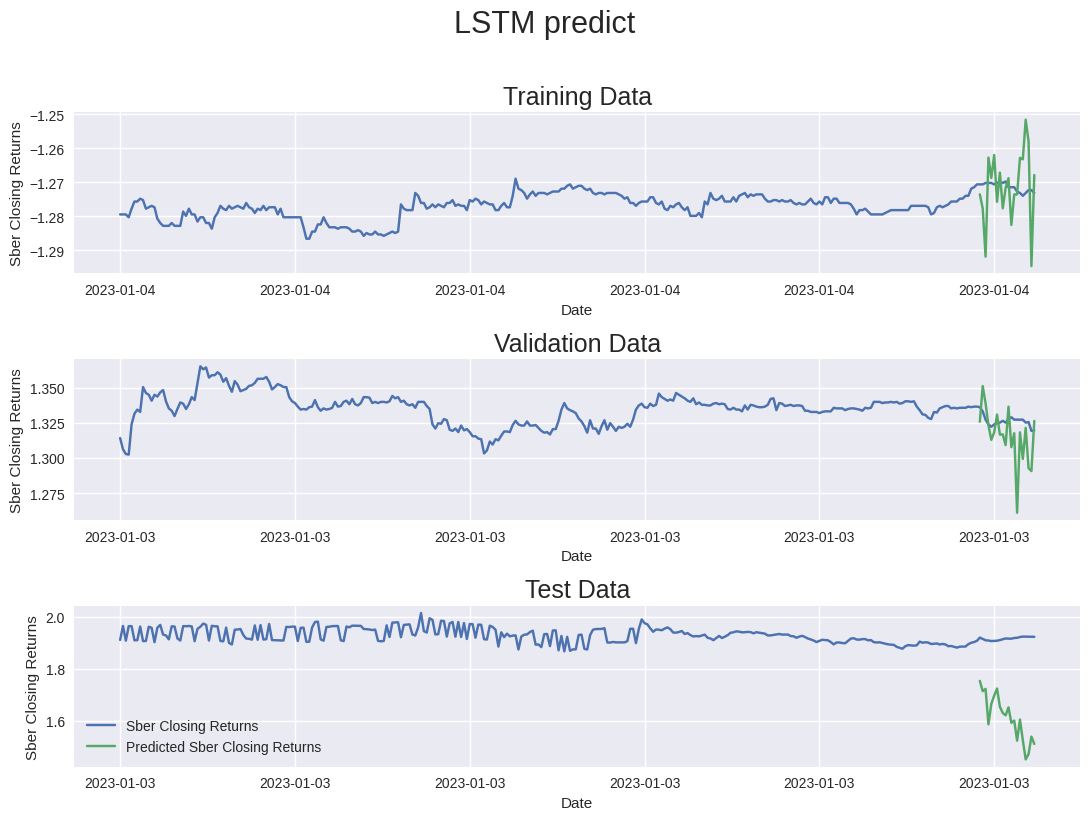

In [ ]:
'''Display results'''

fig = plt.figure(figsize=(11,8))
st = fig.suptitle("LSTM predict", fontsize=22)
st.set_y(1.02)

start_train = 2000

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(np.arange(seq_len + return_len), 
          train_seq[:seq_len + return_len, 1], 
          label='Sber Closing Returns')
ax11.plot(np.arange(seq_len, seq_len + return_len), 
          pred_train, 
          label='Predicted Sber Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Sber Closing Returns')
ax11.set_xticks(range(0, seq_len + return_len, 61))
ax11.set_xticklabels([y.date() for y in df['date'].loc[start_train: start_train + seq_len + return_len:61]])

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(np.arange(seq_len + return_len), 
          val_seq[:seq_len + return_len, 1],
          label='Sber Closing Returns')
ax21.plot(np.arange(seq_len, seq_len + return_len), 
          pred_val,
          label='Predicted Sber Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Sber Closing Returns')
ax21.set_xticks(range(0, seq_len + return_len, 61))
ax21.set_xticklabels([y.date() for y in df['date'].loc[start_val: start_val + seq_len + return_len:61]])

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(np.arange(seq_len + return_len),
          test_seq[:seq_len + return_len, 1], label='Sber Closing Returns')
ax31.plot(np.arange(seq_len, seq_len + return_len), 
          pred_test, 
          label='Predicted Sber Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Sber Closing Returns')
ax31.set_xticks(range(0, seq_len + return_len, 61))
ax31.set_xticklabels([y.date() for y in df['date'].loc[test_val: test_val + seq_len + return_len:61]])
 
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("predict_300_20_models_offset.png")
plt.show()